# What is this?

This is my second attempt at modeling the data and predicting the numbers of the a sample KenKen puzzle. It includes most of the code from 03_modeling_part_1 but is now uses the images stored in 'true_kenken_num_images/' to train on. I also removed everything that had to do with HOG because the neural network was working better (as expected).

In [90]:
import os
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np 

from scipy import ndimage as ndi
from scipy.misc import imsave

from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from skimage.transform import resize
from skimage.measure import find_contours
from skimage.morphology import erosion, dilation, rectangle

%matplotlib inline

In [91]:
IMAGE_DIR = 'distorted_from_true/'
DIR_LIST = ['0','1','2','3','4','5','6','7','8','9','X','plus','minus','div']
IMAGE_SIZE = 28

Import data

In [92]:
def fetch_data():
    dataset = []
    labels = []
    #i is used for creating the one-hot label by adding 1 to the index in a zeros array
    i = 0
    for folder in DIR_LIST:
        #Read each image from the folder in full_image_dir/
        for image in os.listdir(IMAGE_DIR + folder):
            image_file = os.path.join(IMAGE_DIR, folder, image)
            try:
                image_data = ndi.imread(image_file, mode = 'L')
                image_data = resize(image_data, (IMAGE_SIZE,IMAGE_SIZE))
                #print(image_data.shape)

                assert image_data.shape == (IMAGE_SIZE, IMAGE_SIZE)

                dataset.append(image_data)
                
                label = np.zeros(14)
                label[i] += 1
                
                labels.append(label)
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        
        i += 1
                
    features = np.array(dataset)
    labels = np.array(labels)
    return features, labels

In [93]:
features, labels = fetch_data()

## Tensor Flow

In [94]:
import tensorflow as tf

In [95]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=4444)

In [96]:
X_train = np.array([i.reshape(-1) for i in X_train])
X_test = np.array([i.reshape(-1) for i in X_test])

In [97]:
X_train[0].shape

(784,)

In [98]:
type(X_train[0][0])

numpy.float64

In [99]:
X_train.shape

(11544, 784)

In [100]:
##Function for creating batches
def batch_data(x, y, size):
    perm = np.arange(len(x))
    np.random.shuffle(perm)
    x = x[perm]
    y = y[perm]
    return x[:size],y[:size]

In [101]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
    

with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 14])
    W = tf.Variable(tf.zeros([784,14]))
    b = tf.Variable(tf.zeros([14]))

    #Inference
    with tf.name_scope('hidden1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        x_image = tf.reshape(x, [-1,28,28,1])
        hidden1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    with tf.name_scope('hidden2'):
        h_pool1 = max_pool_2x2(hidden1)
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('fully_connected'):
        h_pool2 = max_pool_2x2(h_conv2)
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        fully_connected = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        dropout = tf.nn.dropout(fully_connected, keep_prob)

    with tf.name_scope('softmax'):
        W_fc2 = weight_variable([1024, 14])
        b_fc2 = bias_variable([14])
        y_conv=tf.nn.softmax(tf.matmul(dropout, W_fc2) + b_fc2)

    #Loss
    cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv), name='xentropy')

    #Training
    tf.scalar_summary(cross_entropy.op.name, cross_entropy)
    global_step=tf.Variable(0,name='global_step',trainable=False)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy,global_step=global_step)

    #Evaluation
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    #Prediction
    prediction = tf.argmax(y_conv,1)

    #Initialization
    sess = tf.Session()
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()

    sess.run(init)

    #Restore
    saver.restore(sess,"model_newest.ckpt")

##############################################
# If you are doing this from scratch (meaning#
# no existing 'model_newest.ckpt') then      #
# uncomment the stuff below and comment out  #
# the 'Restore' section above. Let the code  #
# run and then restore the original comments.#
# You also wont need to import all of the    #
# images in the above section to create      #
# training sets since you won't be training  #
##############################################
    
#Training    
'''for i in range(5001):
    batch_x, batch_y = batch_data(X_train, y_train,50)
    if i%500 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch_x, y_: batch_y, keep_prob: 1.0}, session=sess)
        print("step %d, training accuracy %g"%(i, train_accuracy))
    if i%1000 == 0:
        save_path = saver.save(sess,"model_newest.ckpt")
        print("Model saved in file: %s" % save_path)
    train_step.run(feed_dict={x: batch_x, y_: batch_y, keep_prob: 0.5}, session=sess)

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: X_test, y_: y_test, keep_prob: 1.0}, session=sess))
'''

step 0, training accuracy 0.08
Model saved in file: model_newest.ckpt
step 500, training accuracy 1
step 1000, training accuracy 1
Model saved in file: model_newest.ckpt
step 1500, training accuracy 1
step 2000, training accuracy 1
Model saved in file: model_newest.ckpt
step 2500, training accuracy 1
step 3000, training accuracy 1
Model saved in file: model_newest.ckpt
step 3500, training accuracy 1
step 4000, training accuracy 1
Model saved in file: model_newest.ckpt
step 4500, training accuracy 1
step 5000, training accuracy 1
Model saved in file: model_newest.ckpt
test accuracy 1


When you run the training, the accuracy was something like 0.998

Now test on an example image

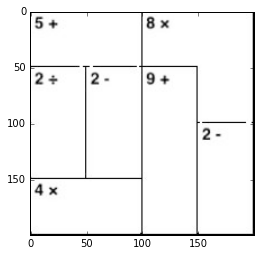

In [16]:
sample4x4_orig = ndi.imread('sample4x4_clean_for_testing.jpg', mode='L')
sample4x4 = resize(sample4x4_orig, (200,200))
plt.imshow(sample4x4, cmap=mpl.cm.Greys_r)

Format of rects is [topleft, topright, bottomright,bottomleft,topleft]

In [17]:
ctrs = find_contours(sample4x4, .85)
rects = [np.array(
        [[min(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]],
         [min(ctr, key=lambda x: x[0])[0],max(ctr, key=lambda x: x[1])[1]],
         [max(ctr, key=lambda x: x[0])[0],max(ctr, key=lambda x: x[1])[1]],
         [max(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]],
         [min(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]]])
          for ctr in ctrs]

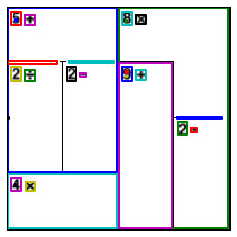

In [18]:
fig, ax = plt.subplots()
ax.imshow(sample4x4[:,:], interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(rects):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [19]:
conversion = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'X', 11:'+',12:'-',13:'/'}

This isn't helpful because of the contour lines picking up the edges and inner circles of numbers (6,8,9)

In [20]:
def binarize(matrix, threshold=0.3):
    temp = deepcopy(matrix)
    for m in range(len(temp)):
        for n in range(len(temp[m])):
            if temp[m][n] < threshold:
                temp[m][n] = 0.0
            else:
                temp[m][n] = 1.0
                
    return temp

### Note
I wrote this new function using the code I came up with in 04_collecting_number_examples.ipynb

In [21]:
def pre_process_image(image_file):
    #get the image and resize
    image_data = ndi.imread(image_file, mode = 'L')
    resized_image = resize(image_data, (200,200))

    #apply the transformations from 01_basic_image_tests.ipynb
    binar = deepcopy(resized_image)
    binar = binarize(binar, 0.6)

    # Get the upleft and lowright black pixels for croping to corners
    # up left
    cond = False
    for m in range(10):
        for n in range(10):
            if binar[m][n] == 0:
                up_left = [m,n]
                cond = True
                break
        if cond==True:
            break

    # low right
    cond = False
    for m in range(199,189,-1):
        for n in range(199,189,-1):
            #print(m,n, binar[m][n])
            if binar[m][n] == 0:
                low_right = [m,n]
                cond = True
                break
        if cond==True:
            break

    resized_image = resize(resized_image[up_left[0]:low_right[0]+1,up_left[1]:low_right[1]+1], (200,200))
    binar = binarize(resized_image, 0.4)

    undilated = deepcopy(binar)

    #dilate the binarized image
    selem = rectangle(1,2)
    dil = dilation(binar, selem)

    #binarize dilation
    dil = binarize(dil)

    #final = dil

    final = deepcopy(dil)
    for i in range(4):
        for j in range(4):
            final[i*50+3:i*50+25,j*50+3:j*50+44] = undilated[i*50+3:i*50+25,j*50+3:j*50+44]

    #Try to remove all borders and grid lines in the image. 
    #Do this by scanning over rows and cols and if more than 25%
    #of the pixels are <= 0.45 then set the entire row to 1(white)

    #first rows
    for row in range(len(final)):
        count = 0
        for pixel in final[row,:]:
            if pixel == 0:
                count += 1
        if count >= 48:
            final[row,:] = final[row,:]*0 + 1

    #columns
    for col in range(len(final[0,:])):
        count = 0
        for pixel in final[:,col]:
            if pixel == 0:
                count += 1
        if count >= 48:
            final[:,col] = final[:,col]*0 + 1
            
    #add some final erosion (black) to fill out numbers and ensure they're connected
    final = binarize(erosion(final, rectangle(1,2)),.0000001)
    
    return final


In [22]:
final = pre_process_image('sample4x4_1.jpg')

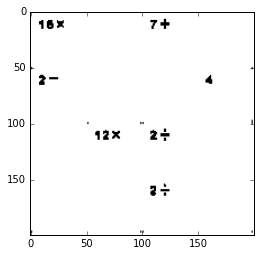

In [23]:
plt.imshow(final, cmap=mpl.cm.Greys_r)

3 numbers/symbols found in quadrant 0,0
0 numbers/symbols found in quadrant 0,1
2 numbers/symbols found in quadrant 0,2
0 numbers/symbols found in quadrant 0,3
2 numbers/symbols found in quadrant 1,0
0 numbers/symbols found in quadrant 1,1
0 numbers/symbols found in quadrant 1,2
1 numbers/symbols found in quadrant 1,3
0 numbers/symbols found in quadrant 2,0
3 numbers/symbols found in quadrant 2,1
2 numbers/symbols found in quadrant 2,2
0 numbers/symbols found in quadrant 2,3
0 numbers/symbols found in quadrant 3,0
0 numbers/symbols found in quadrant 3,1
2 numbers/symbols found in quadrant 3,2
0 numbers/symbols found in quadrant 3,3
15 numbers/symbols found in image


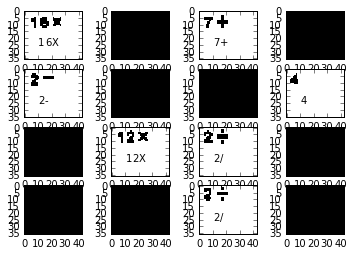

In [84]:
#the regions in the image that will be searched for contours
regions_of_interest = [final[3:39,3:46],
                      final[3:39,53:96],
                      final[3:39,103:146],
                      final[3:39,153:196],
                      final[53:89,3:46],
                      final[53:89,53:96],
                      final[53:89,103:146],
                      final[53:89,153:196],
                      final[103:139,3:46],
                      final[103:139,53:96],
                      final[103:139,103:146],
                      final[103:139,153:196],
                      final[153:189,3:46],
                      final[153:189,53:96],
                      final[153:189,103:146],
                      final[153:189,153:196]
                      ]


#get the contour lines and make a bounding box of each contour
total_images_found = 0
fig = plt.figure()
x_count = 0
y_count = 0
plot_counter = 1
for region in regions_of_interest:  
    #Results is where the sub-ROIs will be stored
    results = []
    ctrs = find_contours(region, .9)
    rects = [np.array(
            [[min(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]],
             [min(ctr, key=lambda x: x[0])[0],max(ctr, key=lambda x: x[1])[1]],
             [max(ctr, key=lambda x: x[0])[0],max(ctr, key=lambda x: x[1])[1]],
             [max(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]],
             [min(ctr, key=lambda x: x[0])[0],min(ctr, key=lambda x: x[1])[1]]])
              for ctr in ctrs]

    #print(rects)

    #loop over the bounding boxes and store that region, the regions will need 
    #to be filtered so that there aren't regions within regions
    for rect in rects:
        try:
            pt1 = rect[0][0] #m min
            pt2 = rect[2][0] #m max
            pt3 = rect[0][1] #n min
            pt4 = rect[1][1] #n max
            results.append([pt1,pt2,pt3,pt4])

        except:
            print('There was an error')


    #filter out a result contained in another result
    #This isn't very efficient and will likely need a better
    #algorithm for images taken with a camera but it works well for now
    for result in results:
        temp = [res for res in results if res != result]
        for other in temp:
            if result[0] >= other[0] and result[1] <= other[1] and\
            result[2] >= other[2] and result[3] <= other[3]:
                try:
                    results.remove(result)
                except ValueError as e:
                    print('Error removing result from results, ', e)

    #combine those with similar midpoints (mainly used for finding division symbols)
    midpoints = [(result[3]-result[2])/2+result[2] for result in results]
    
    new_results = []
    for i,result in enumerate(results):
        diff = [j for j, m in enumerate(midpoints) if abs(m-midpoints[i]) < 3]
        #need to reinitialize new_results between loops
        if len(diff) > 1:
            new_results = [result for j,result in enumerate(results) if j not in diff]
            similar_obj = np.array([results[j] for j in diff])
            new_object = np.array([min(similar_obj[:,0]),
                                  max(similar_obj[:,1]),
                                  min(similar_obj[:,2]),
                                  max(similar_obj[:,3])])
            #print(new_object)
            new_results.append(list(new_object))

            break
        else:
            continue
    
    #assign new_results to results if new results were obtained
    try:
        if len(new_results) > 0:
            results = new_results
    except:
        pass
    
    
    #now make a new prediction on the results:
    new_results = []
    for result in results:
        new_res = deepcopy(result)
        roi = region[int(result[0]):int(result[1])+1, int(result[2]):int(result[3])+1] 
        roi = resize(roi, (28, 28)).reshape(1,784)
        nbr = prediction.eval(feed_dict={x:roi, keep_prob:1.0}, session=sess)[0]
        new_res.append(conversion[nbr])
        new_results.append(new_res)

        
    try:
        if len(new_results) > 0:
            results = new_results
    except:
        pass
    
    #Sort the results by furthest box to the left 
    results = sorted(results, key=lambda x: x[2])

    #Plot all of the subplots
    plt.subplot(4,4,plot_counter)
    plot_counter+=1
    plt.imshow(region, interpolation='nearest', cmap=plt.cm.gray)

    '''for contour in rects:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)'''

    z = 0
    for res in results:
        plt.annotate('{}'.format(res[4]), xy=(10+z*5,25))
        z+=1
    
    #Loop again over the filtered results, count how many there are
    num_sym_found = 0
    for result in results:
        num_sym_found += 1      

    print('{} numbers/symbols found in quadrant {},{}'.format(num_sym_found, x_count,y_count))
    y_count+=1
    if y_count == 4:
        y_count = 0
        x_count += 1
    total_images_found+=num_sym_found

print('{} numbers/symbols found in image'.format(total_images_found))

### Remarks on this modeling attempt

Wow! This was a perfect prediction. Will be using this for the final project.